In [1]:
# Import libraries:
import xarray
import numpy as np
import pandas as pd
import os
#from six.moves import urllib
from glob import glob
import matplotlib.pyplot as plt
import matplotlib  as mpl 
import pickle
import pyart
from datetime import datetime
import math
from pandas.core.common import flatten
%matplotlib inline
#%matplotlib widget


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Import tobac itself:
import tobac
from tobac.merge_split import merge_split
from tobac.utils import standardize_track_dataset, compress_all
#Disable a couple of warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def qc_reflectivity2(dataset,rhv, ref = None):
    for i in range(len(dataset['time'])):
        refl = np.array(dataset['reflectivity'][i, :, :, :])
        refl[np.array(dataset['cross_correlation_ratio'][i, :, :, :]) < rhv] = -999 #0
        #refl[np.array(dataset['correlation_coefficient'][i, :, :, :]) < rhv] = -999 #0
        if ref:
            refl[refl < ref] = np.nan #-999 #0
        dataset['reflectivity'][i, :, :, :] = refl
        max_refl = dataset['reflectivity'].max(axis=1,skipna=True)
        #p = np.where(max_refl)
        #dataset = dataset.assign(max_reflectivity=lambda dataset:max_refl)
    return max_refl

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
path = "/Users/kelcy/DATA/20220604/KHGX20220604_*_V06_grid.nc"
path = "/Users/kelcy/DATA/20160331/20160331_gridded_KHTX/grid_KHTX20160*_V06.nc"
data = xarray.open_mfdataset(path, engine = 'netcdf4')
data['time'].encoding['units']="seconds since 2000-01-01 00:00:00"
rho = 0.90
ref =  10
maxrefl = qc_reflectivity2(data,rho,ref = ref)

# maxrefl.to_netcdf(os.path.join(savedir,'20220604_maxrefl.nc'))

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#Set up directory to save output and plots:
savedir='tobac_Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir="tobac_Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Feature detection:
#Feature detection is perfomed based on surface precipitation field and a range of thresholds

In [6]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']= 1.0 #0.5 is the default
parameters_features['threshold']= 15 
#parameters_features['min_num']=0
#parameters_features['min_distance']=5 #0 #15
#parameters_features['n_erosion_threshold']=0
#parameters_features['n_min_threshold']=0

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#Dt, DXY
datetimes = data['time']
timedeltas = [(datetimes[i-1]-datetimes[i]).astype('timedelta64[m]') for i in range(1, len(datetimes))]
print(len(timedeltas))
average_timedelta = sum(timedeltas) / len(timedeltas)
dt = np.abs(np.array(average_timedelta)).astype('timedelta64[m]').astype(int)


deltax = [data['x'][i-1]-data['x'][i] for i in range(1, len(data['x']))]
dxy = np.abs(np.mean(deltax).astype(int))/1000


print(dxy,dt)
# dxy = 0.5
# dt = 5

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


152
0.5 4


In [8]:
maxrefl_iris=maxrefl.to_iris()
# Feature detection based on based on surface precipitation field and a range of thresholds
print('starting feature detection based on multiple thresholds')
Features_iris=tobac.feature_detection_multithreshold(maxrefl_iris,dxy,**parameters_features)
Features=Features_iris.to_xarray()
print('feature detection done')
Features.to_netcdf(os.path.join(savedir,'Features.nc'))
print('features saved')

starting feature detection based on multiple thresholds


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/iris/fileformats/_ff.py:819: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def _parse_binary_stream(file_like, dtype=np.float, count=-1):
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/skimage/morph

feature detection done
features saved


In [9]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=15  # mm/h mixing ratio
#parameters_segmentation['ISO_dilate']=10 #this is the size 
#parameters_segmentation['features']
#parameters_segmentation['field']
#parameters_segmentation['dxy']
#parameters_segmentation['target']
#parameters_segmentation['level']
#parameters_segmentation['method']
#parameters_segmentation['max_distance']
#Maximum distance from a marker allowed to be classified as
        #belonging to that cell. Default is None.
#parameters_segmentation['vertical_coord']

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
Features_df=Features.to_dataframe()

# Perform Segmentation and save resulting mask to NetCDF file:
print('Starting segmentation based on reflectivity')
Mask_iris,Features_Precip =tobac.segmentation.segmentation(Features_df,maxrefl_iris,dxy,**parameters_segmentation)
#Mask,Features_Precip=tobac.themes.tobac_v1.segmentation(Features,maxrefl,dxy,**parameters_segmentation)
Features_Precip=Features_Precip.to_xarray()
Mask=xarray.DataArray.from_iris(Mask_iris)
Mask = Mask.to_dataset()


#Mask,Features_Precip=segmentation(Features,maxrefl,dxy,**parameters_segmentation)
print('segmentation based on reflectivity performed, start saving results to files')
Mask.to_netcdf(os.path.join(savedir,'Mask_Segmentation_refl.nc'))                
Features_Precip.to_netcdf(os.path.join(savedir,'Features_Precip.nc'))
print('segmentation reflectivity performed and saved')

Starting segmentation based on reflectivity


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


segmentation based on reflectivity performed, start saving results to files
segmentation reflectivity performed and saved


In [11]:
areas = np.zeros([(len(Features['index'])+1)])
maxfeature_refl = np.zeros([(len(Features['index'])+1)])
#Mask = Mask.to_dataset()
frame_features = Features.groupby('frame')

for frame_i, features_i in frame_features: 
#     print(frame_i)
#     print(features_i)
    mask_i = Mask['segmentation_mask'][frame_i,:,:].values
    subrefl = maxrefl[frame_i,:,:].values
    for i in np.unique(mask_i):
        feature_area_i = np.where(mask_i == i)
        areas[i] = len(feature_area_i[0])
        maxfeature_refl[i] = np.nanmax(subrefl[feature_area_i])


var = Features['feature'].copy(data = areas[1:])
var = var.rename("areas")
var_max = Features['feature'].copy(data = maxfeature_refl[1:])
var_max = var_max.rename("max_reflectivity")
Features_Precip = xarray.merge([Features_Precip,var], compat = 'override')
Features = xarray.merge([Features,var], compat = 'override')
Features = xarray.merge([Features,var_max], compat = 'override')
Features_Precip.to_netcdf(os.path.join(savedir, 'Features_Precip.nc'))
Features.to_netcdf(os.path.join(savedir,'Features.nc'))
Mask = Mask.to_array()
Features_df=Features.to_dataframe()
print('features saved')

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


features saved


In [12]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 3#5
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=2 #was 1 - the number of frames to extrapolate to
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 #50 #100
parameters_linking['memory']= 2
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=1.0#.5
parameters_linking['d_min']= None #5

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:

#Track=tobac.themes.tobac_v1.linking_trackpy(Features,Mask,dt=dt,dxy=dxy,**parameters_linking)
Features_df=Features.to_dataframe()
Track=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)
Track = Track.to_xarray()
Track.to_netcdf(os.path.join(savedir,'Track.nc'))

Frame 152: 97 trajectories present.


In [14]:
Track = xarray.open_dataset(savedir+"/Track.nc")
Track = Track.to_dataframe()
Features = xarray.open_dataset(savedir+"/Features.nc")
refl_mask = xarray.open_dataset(savedir+"/Mask_Segmentation_refl.nc")
refl_features = xarray.open_dataset(savedir+"/Features_Precip.nc")

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
d = merge_split(Track,distance = 20000., dxy = dxy)
Track = Track.to_xarray()
ds = standardize_track_dataset(Track, refl_mask, data['ProjectionCoordinateSystem'])
both_ds = xarray.merge([ds, d],compat ='override')
both_ds = compress_all(both_ds)
both_ds.to_netcdf(os.path.join(savedir,'Track_features_merges.nc'))

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


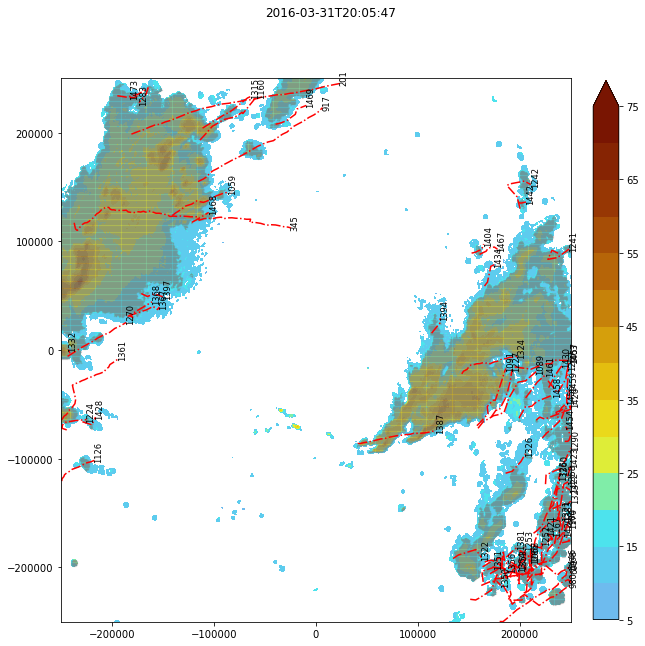

In [24]:
frame = 33

#
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] #data['max_reflectivity'][id,:,:]
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])# + 'rhohv = '+str(rho) + ', ref > ' + str(ref))
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(refl_mask['segmentation_mask'][frame,:,:] > 0)
#print(str(len(np.unique(refl_mask['segmentation_mask'][frame,:,:]))) + ' unique mask shapes')
y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.5)
# plt.xlim([-50000,50000])
# plt.ylim([-100000,0])
# plt.xlim([-250000,-150000])
# plt.ylim([-140000,-40000])

# iso = 0
# not_iso = 0
# for i in np.unique(refl_mask['segmentation_mask'][frame,:,:]): #True means there's something around the feature
#     if i == 0:
#         not_iso += 1
#         continue
#     else:
#         if refl_features['num_objects'][int(i-1)].data == 2:
#             iso += 1
#     #if refl_features['isolated'][int(i-1)].data == False: #referencing by index count starts at 0, referencing by finding or where count is true.
#         #i -= 1
#             p = np.where(refl_mask['segmentation_mask'][frame,:,:] == i)
#             y, x = y_mesh[p[0],p[1]],x_mesh[p[0],p[1]]
#             imcell2 = ax.scatter(y,x,s = 0.1,c = 'purple', marker = '.',alpha = 0.5)
#         if refl_features['num_objects'][int(i-1)].data > 2:
#             not_iso += 1

# print(not_iso)
# print(iso)
# print(len(np.unique(refl_mask['segmentation_mask'][frame,:,:]))-1)

for i in np.unique(Track['cell']):
    if i < 0:
        continue
    if math.isfinite(i):
        track_i = np.where(Track['cell'] == i)
        
        if np.any(Track['frame'][track_i] == frame):
            ax.plot(Track['projection_x_coordinate'][track_i], Track['projection_y_coordinate'][track_i], '-.',color='r')
            #ax.plot(Track['x'][track_i], Track['y'][track_i], '-.',color='r')
            ax.text(Track['projection_x_coordinate'][track_i][-1],Track['projection_y_coordinate'][track_i][-1], f'{int(i)}',fontsize = 'small',rotation = 'vertical')
        else:
            continue

# #     for i in [743]:           
# for i in track_id[236]: #np.unique(Track['cell']):634,943
# #         if i < 1299:
# #             continue
#         track_i = np.where(Track['cell'] == i)
#     #ax.plot(Track['x'][track_i], Track['y'][track_i], '-.',color='b')
#     #ax.text(Track['x'][track_i][-1],Track['y'][track_i][-1], f'Tr {int(i)}')
#         ax.plot(Track['projection_x_coordinate'][track_i], Track['projection_y_coordinate'][track_i], '-.',color='b')
#         #ax.text(Track['projection_x_coordinate'][track_i][3],Track['projection_y_coordinate'][track_i][3], f'{int(i)}',
#                 #fontsize = 'small',rotation = 'vertical')



In [25]:
import numpy as np
import warnings
import xarray as xr

from scipy import ndimage
from datetime import datetime

try:
    import pyproj
    _PYPROJ_AVAILABLE = True
except ImportError:
    _PYPROJ_AVAILABLE = False

def cartesian_to_geographic_aeqd(x, y, lon_0, lat_0, R=6370997.):
    """
    Azimuthal equidistant Cartesian to geographic coordinate transform.

    Transform a set of Cartesian/Cartographic coordinates (x, y) to
    geographic coordinate system (lat, lon) using a azimuthal equidistant
    map projection [1]_.

    .. math::

        lat = \\arcsin(\\cos(c) * \\sin(lat_0) +
                       (y * \\sin(c) * \\cos(lat_0) / \\rho))

        lon = lon_0 + \\arctan2(
            x * \\sin(c),
            \\rho * \\cos(lat_0) * \\cos(c) - y * \\sin(lat_0) * \\sin(c))

        \\rho = \\sqrt(x^2 + y^2)

        c = \\rho / R

    Where x, y are the Cartesian position from the center of projection;
    lat, lon the corresponding latitude and longitude; lat_0, lon_0 are the
    latitude and longitude of the center of the projection; R is the radius of
    the earth (defaults to ~6371 km). lon is adjusted to be between -180 and
    180.

    Parameters
    ----------
    x, y : array-like
        Cartesian coordinates in the same units as R, typically meters.
    lon_0, lat_0 : float
        Longitude and latitude, in degrees, of the center of the projection.
    R : float, optional
        Earth radius in the same units as x and y. The default value is in
        units of meters.

    Returns
    -------
    lon, lat : array
        Longitude and latitude of Cartesian coordinates in degrees.

    References
    ----------
    .. [1] Snyder, J. P. Map Projections--A Working Manual. U. S. Geological
        Survey Professional Paper 1395, 1987, pp. 191-202.

    """
    x = np.atleast_1d(np.asarray(x))
    y = np.atleast_1d(np.asarray(y))

    lat_0_rad = np.deg2rad(lat_0)
    lon_0_rad = np.deg2rad(lon_0)

    rho = np.sqrt(x*x + y*y)
    c = rho / R

    with warnings.catch_warnings():
        # division by zero may occur here but is properly addressed below so
        # the warnings can be ignored
        warnings.simplefilter("ignore", RuntimeWarning)
        lat_rad = np.arcsin(np.cos(c) * np.sin(lat_0_rad) +
                            y * np.sin(c) * np.cos(lat_0_rad) / rho)
    lat_deg = np.rad2deg(lat_rad)
    # fix cases where the distance from the center of the projection is zero
    lat_deg[rho == 0] = lat_0

    x1 = x * np.sin(c)
    x2 = rho*np.cos(lat_0_rad)*np.cos(c) - y*np.sin(lat_0_rad)*np.sin(c)
    lon_rad = lon_0_rad + np.arctan2(x1, x2)
    lon_deg = np.rad2deg(lon_rad)
    # Longitudes should be from -180 to 180 degrees
    lon_deg[lon_deg > 180] -= 360.
    lon_deg[lon_deg < -180] += 360.

    return lon_deg, lat_deg

def cartesian_to_geographic(grid_ds):
    """
    Cartesian to Geographic coordinate transform.

    Transform a set of Cartesian/Cartographic coordinates (x, y) to a
    geographic coordinate system (lat, lon) using pyproj or a build in
    Azimuthal equidistant projection.

    Parameters
    ----------
    grid_ds: xarray DataSet
        Cartesian coordinates in meters unless R is defined in different units
        in the projparams parameter.

    Returns
    -------
    lon, lat : array
        Longitude and latitude of the Cartesian coordinates in degrees.

    """
    projparams = grid_ds.ProjectionCoordinateSystem
    x = grid_ds.x.values
    y = grid_ds.y.values
    z = grid_ds.z.values
    z, y, x = np.meshgrid(z, y, x, indexing='ij')
    if projparams.attrs['grid_mapping_name'] == 'azimuthal_equidistant':
        # Use Py-ART's Azimuthal equidistance projection
        lat_0 = projparams.attrs['latitude_of_projection_origin']
        lon_0 = projparams.attrs['longitude_of_projection_origin']
        if 'semi_major_axis' in projparams:
            R = projparams.attrs['semi_major_axis']
            lon, lat = cartesian_to_geographic_aeqd(x, y, lon_0, lat_0, R)
        else:
            lon, lat = cartesian_to_geographic_aeqd(x, y, lon_0, lat_0)
    else:
        # Use pyproj for the projection
        # check that pyproj is available
        if not _PYPROJ_AVAILABLE:
            raise MissingOptionalDependency(
                "PyProj is required to use cartesian_to_geographic "
                "with a projection other than pyart_aeqd but it is not "
                "installed")
        proj = pyproj.Proj(projparams)
        lon, lat = proj(x, y, inverse=True)
    return lon, lat


def add_lat_lon_grid(grid_ds):
    lon, lat = cartesian_to_geographic(grid_ds)
    grid_ds["point_latitude"] = xr.DataArray(lat, dims=["z", "y", "x"])
    grid_ds["point_latitude"].attrs["long_name"] = "Latitude"
    grid_ds["point_latitude"].attrs["units"] = "degrees"
    grid_ds["point_longitude"] = xr.DataArray(lon, dims=["z", "y", "x"])
    grid_ds["point_longitude"].attrs["long_name"] = "Latitude"
    grid_ds["point_longitude"].attrs["units"] = "degrees"
    return grid_ds

def parse_grid_datetime(my_ds):
    year = my_ds['time'].dt.year
    month = my_ds['time'].dt.month
    day = my_ds['time'].dt.day
    hour = my_ds['time'].dt.hour
    minute = my_ds['time'].dt.minute
    second = my_ds['time'].dt.second
    return datetime(year=year, month=month, day=day,
                    hour=hour, minute=minute, second=second)


# def get_vert_projection(grid, thresh=40):
#     """ Returns boolean vertical projection from grid. """
#     return np.any(grid > thresh, axis=0)


# def get_filtered_frame(grid, min_size, thresh):
#     """ Returns a labeled frame from gridded radar data. Smaller objects
#     are removed and the rest are labeled. """
#     if len(grid.shape) == 3:
#         echo_height = get_vert_projection(grid, thresh)
#     else:
#         echo_height = grid > thresh
#     labeled_echo = ndimage.label(echo_height)[0]
#     frame = clear_small_echoes(labeled_echo, min_size)
#     return frame


# def clear_small_echoes(label_image, min_size):
#     """ Takes in binary image and clears objects less than min_size. """
#     flat_image = label_image.flatten()
#     flat_image = flat_image[flat_image > 0]
#     unique_elements, size_table = np.unique(flat_image, return_counts=True)
#     small_objects = unique_elements[size_table < min_size]

#     for obj in small_objects:
#         label_image[label_image == obj] = 0
#     label_image = ndimage.label(label_image)
#     return label_image[0]


# def get_grid_alt(grid_z, alt_meters=1500):
#     """ Returns z-index closest to alt_meters. """
#     return np.argmin(np.abs(grid_z - alt_meters))


# def extract_grid_data(grid_obj, field, grid_size, params):
#     """ Returns filtered grid frame and raw grid slice at global shift
#     altitude. """
#     min_size = params['MIN_SIZE'] / np.prod(grid_size[1:]/1000)
#     masked = grid_obj.variables[field].fillna(0).values
#     gs_alt = params['GS_ALT']
#     raw = masked[get_grid_alt(grid_obj.z.values, gs_alt), :, :]
#     frame = get_filtered_frame(masked, min_size, params['FIELD_THRESH'])
#     return raw, frame


# def get_grid_size(grid_obj):
#     z_len = grid_obj.z.values[-1] - grid_obj.z.values[0]
#     x_len = grid_obj.x.values[-1] - grid_obj.x.values[0]
#     y_len = grid_obj.y.values[-1] - grid_obj.y.values[0]
#     z_size = z_len / (grid_obj.z.values.shape[0] - 1)
#     x_size = x_len / (grid_obj.x.values.shape[0] - 1)
#     y_size = y_len / (grid_obj.y.values.shape[0] - 1)
#     return np.array([z_size, y_size, x_size])


# def extract_grid_data_2d(grid_obj, field, params):
#     grid_size = np.array(grid_obj[field].values.shape)
#     min_size = params['MIN_SIZE']
#     masked = grid_obj.variables[field].values
#     masked = masked > params['FIELD_THRESH']
#     print(np.sum(masked))
#     raw = masked
#     labeled_echo = ndimage.label(masked)[0]
#     frame = clear_small_echoes(labeled_echo, min_size)
#     return raw, frame    



""" X-Array based TINT I/O module. """

import xarray as xr
import random
import numpy as np
import pyproj

#from .grid_utils import add_lat_lon_grid
from datetime import datetime

def load_cfradial_grids(file_list):
    ds = xr.open_mfdataset(file_list)
    # Check for CF/Radial conventions
    if not ds.attrs["Conventions"] == 'CF/Radial instrument_parameters':
        ds.close()
        raise IOError("TINT module is only compatible with CF/Radial files!")
    ds = add_lat_lon_grid(ds)
#     ds.attrs["cf_tree_order"] = "storm_id cell_id"
#     ds.attrs["tree_id"] = "%d" % random.randint(a=0, b=65535)
#     # Try to detect number of fields (4D arrays)
#     nfields = 0
#     for keys in ds.variables.keys():
#         if(len(ds[keys].dims) == 3):
#             nfields += 1

#     ds['storm_id'] = ('storm', np.arange(0, nfields, 1))
#     ds['storm_id'].attrs["child"] = "cell"
#     ds['storm_id'].attrs["tree_id"] = ds.attrs["tree_id"]

    return ds

nc_grid = load_cfradial_grids(path)

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
longitude = []
for i in range(len(Track['time'])):
    #longitude.append(np.mean(nc_grid['point_longitude'].sel({'x':Track['x'].data[i]},method='nearest').data))       
    longitude.append(np.mean(nc_grid['point_longitude'].sel({'x':Track['projection_x_coordinate'].data[i]},method='nearest').data))       


    
latitude = []
for i in range(len(Track['time'])):
    #latitude.append(np.mean(nc_grid['point_latitude'].sel({'y':Track['y'].data[i]},method='nearest').data))     
    latitude.append(np.mean(nc_grid['point_latitude'].sel({'y':Track['projection_y_coordinate'].data[i]},method='nearest').data))     


latitude = np.array(latitude)
longitude = np.array(longitude)
#Track['latitude'] = latitude
#Track['longitude'] = longitude

nc_lons = nc_grid['point_longitude'][0,:,:].data
nc_lats = nc_grid['point_latitude'][0,:,:].data

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
nc_grid['ProjectionCoordinateSystem'][0].attrs

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'latitude_of_projection_origin': 34.93055725097656,
 'longitude_of_projection_origin': -86.08361053466797,
 '_CoordinateTransformType': 'Projection',
 '_CoordinateAxes': 'x y z time',
 '_CoordinateAxesTypes': 'GeoX GeoY Height Time',
 'grid_mapping_name': 'azimuthal_equidistant',
 'semi_major_axis': 6370997.0,
 'inverse_flattening': 298.25,
 'longitude_of_prime_meridian': 0.0,
 'false_easting': 0.0,
 'false_northing': 0.0}

In [62]:
#plt.close('all')
#fig = plt.figure(figsize=(9,9))

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid

def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    

def plot(t_index,xrdata,max_refl,features,mask,track, ncgrid,dbz,lons,lats,nclon,nclat,ind = None):
    # Get the data
    hsv_ctr_lat, hsv_ctr_lon = 29.4719, -95.0792
    
    #hsv_ctr_lat, hsv_ctr_lon = 34.5550, -86.0500


    refl = max_refl[t_index,:,:]

    t_step = str(ncgrid['time'][t_index].values)
    print(t_step)
    
    fname = "/Users/kelcy/Downloads/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lines.shp"
    # Plot
    #fig.clear()
    latlon_proj = ccrs.PlateCarree()
    cs_attrs = ncgrid['ProjectionCoordinateSystem'][0].attrs
    if cs_attrs['grid_mapping_name'] == 'azimuthal_equidistant':
        grid_proj = ccrs.AzimuthalEquidistant(central_latitude=cs_attrs['latitude_of_projection_origin'],
                central_longitude=cs_attrs['longitude_of_projection_origin'],
                false_easting=cs_attrs['false_easting'],
                false_northing=cs_attrs['false_northing'],)
    projection=grid_proj
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    axs = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.4,
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.4,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode
    for ax in axs:
        ax.coastlines()
        shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), edgecolor='black')
        ax.add_feature(shape_feature, facecolor='none')
        ax.add_feature(cartopy.feature.STATES, edgecolor = 'black')
        ax.set_extent((hsv_ctr_lon-2.5, hsv_ctr_lon+2.5,
                    hsv_ctr_lat-3.0, hsv_ctr_lat+2.5))

        
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
    
    # Gridded background
    grid_extent = (ncgrid.x.min(), ncgrid.x.max(),
                   ncgrid.y.min(), ncgrid.y.max())
    
    #fig.suptitle((t_step[0:19] + ' 40 dbz, long tracks, ISO_THRESH = 12'), fontsize = 12,y=0.76)


    # Cell ID
    im = axs[0].imshow(refl,origin = 'lower', vmin=-25, vmax=85, cmap='pyart_LangRainbow12',extent = grid_extent, transform = grid_proj)
    axs[0].set_title((t_step[0:19]+' ' + str(dbz)+' dbz, Tobac'))
    axs.cbar_axes[0].colorbar(im)

    track_cell = track.groupby('cell')
    times = np.unique(track['time'])
    track_time = track.groupby('time')

    i = np.where(mask['segmentation_mask'][t_index,:,:] > 0)
    y1, x1 = nclon[i[0],i[1]],nclat[i[0],i[1]]
#             axs[0].plot(y1,x1, marker = '.',color = 'gray',
#                     alpha = 0.05,linestyle='dashed',transform=latlon_proj,linewidth=1, markersize=1)
    axs[0].scatter(y1,x1, s = 0.1,c = 'gray', marker = '.',alpha = 0.2, transform = latlon_proj)


    for i in np.unique(track['cell']):
        
        if i < 0:
            continue
        if math.isfinite(i):

            track_i = np.where(track['cell'] == i)

            times = str(track['time'][track_i].data)
            if np.any(times[:-13] == t_step[:-13]):
                track_i = np.array(track_i)
                track_i = np.squeeze(track_i)
                track_i = track_i.astype(int)
                axs[0].plot(lons[track_i], lats[track_i], '-.',
                        color='r',markersize = 1,transform = latlon_proj)
                axs[0].text(lons[track_i][-1],lats[track_i][-1], f'Tr {int(i)}',transform = latlon_proj,rotation=90,fontsize=8)
        else:
            continue



/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321:

2016-03-31T18:04:20.000000000
3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

3
5
6
8
11
12
17
21
25
27
29
30
35
37
38
39
42
43
47
49
51
53
59
61
69
71
72
73
74
76
77
78
79
82
86
89
95
96
106
134
135
136
137
139
143
146
148
159
165
166
168
170
173
176
180
181
186
194
201
203
206
215
218
219
231
233
234
239
241
246
247
248
249
253
256
257
260
268
269
270
272
277
289
310
312
314
315
318
322
323
324
325
326
328
330
331
332
345
354
356
359
360
364
369
372
374
376
378
401
402
403
406
410
423
425
426
429
430
437
447
450
451
458
468
469
470
485
486
489
490
491
492
494
498
500
508
515
517
518
520
521
522
523
524
525
537
542
545
552
553
554
559
561
563
564
566
569
571
572
573
576
583
584
585
587
589
591
592
594
595
600
601
602
605
606
607
610
613
614
616
619
620
623
627
638
644
645
648
656
660
665
667
673
675
676
684
687
689
690
691
693
695
697
701
710
712
713
714
717
719
721
728
730
731
733
734
735
738
739
743
749
753
754
755
760
768
769
775
776
777
782
783
786
788
792
793
801
806
807
808
809
815
818
819
820
826
828
829
835
837
844
845
848
850
854
856
857
858
860
862
86

KeyboardInterrupt: 

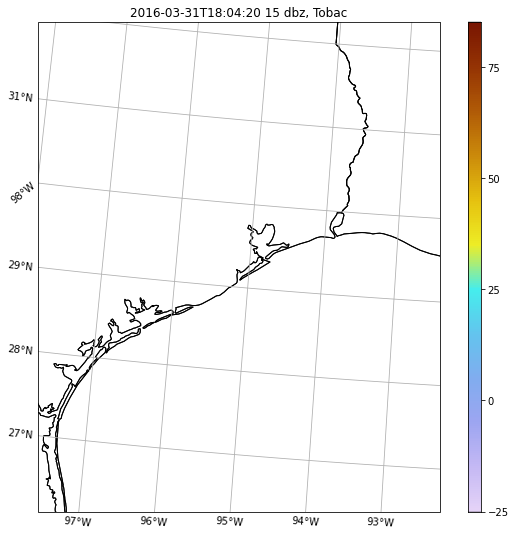

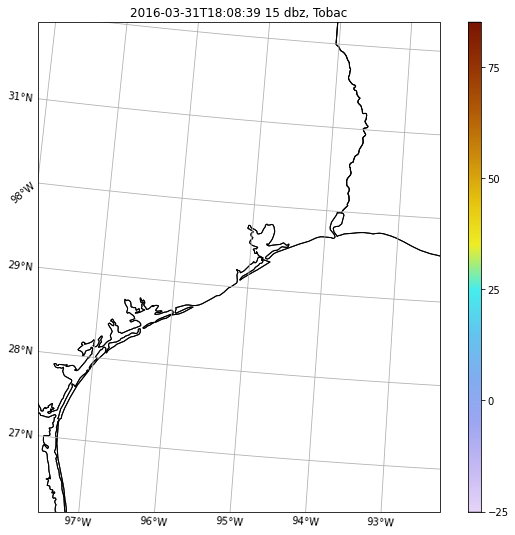

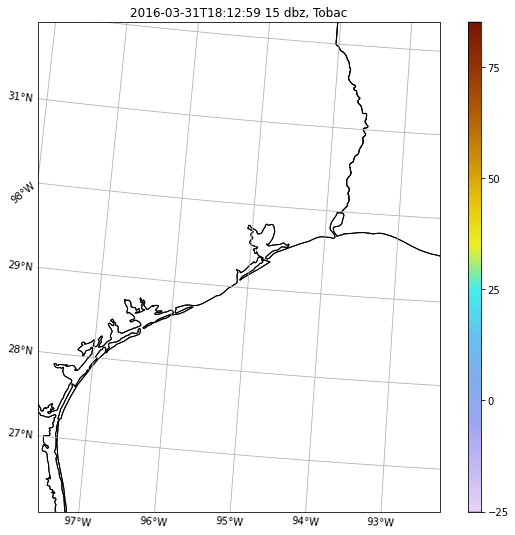

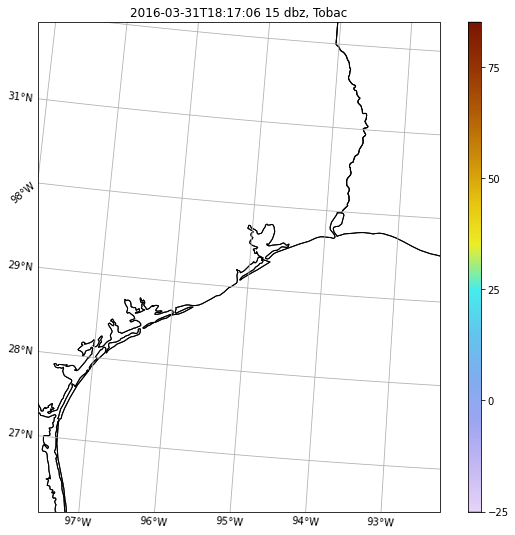

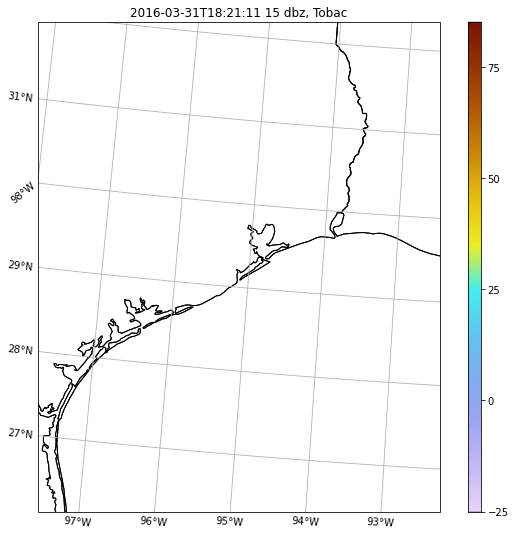

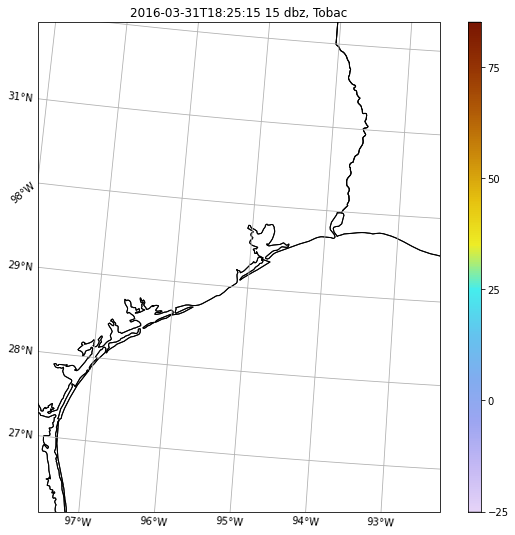

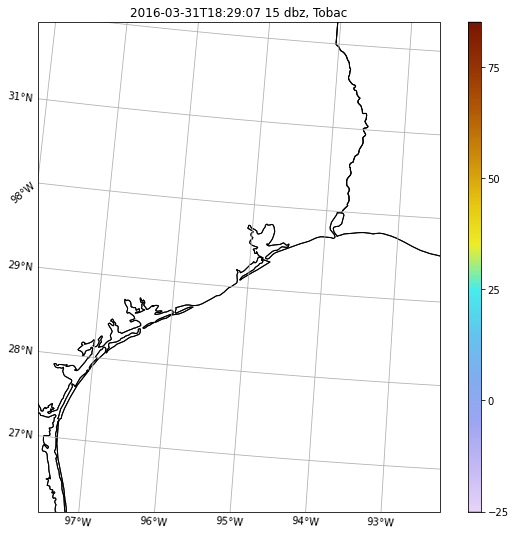

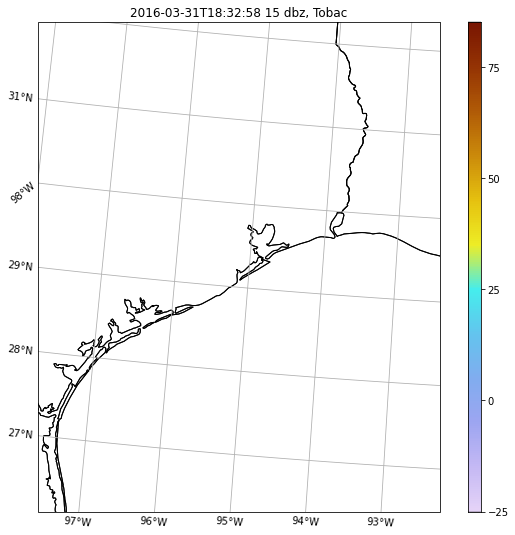

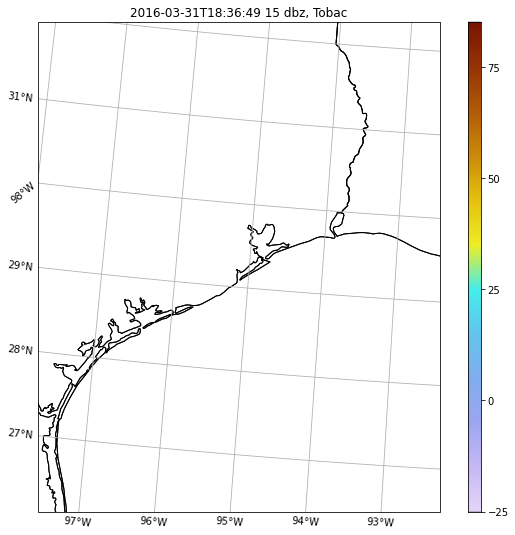

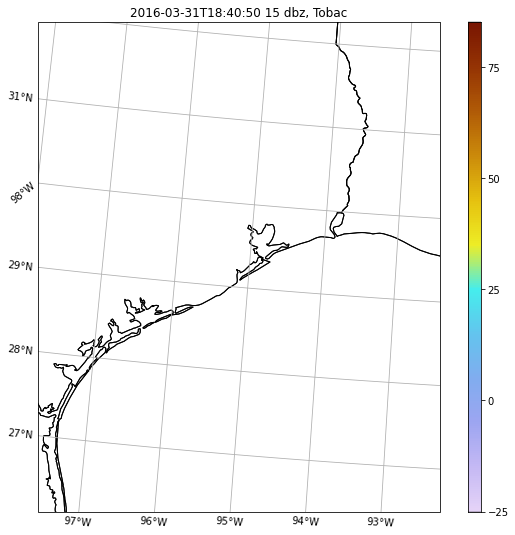

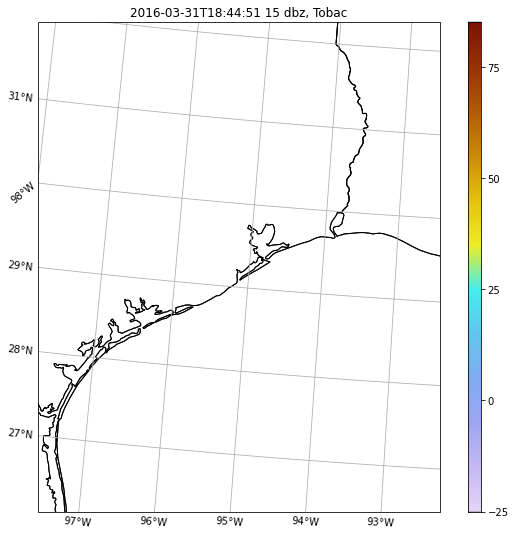

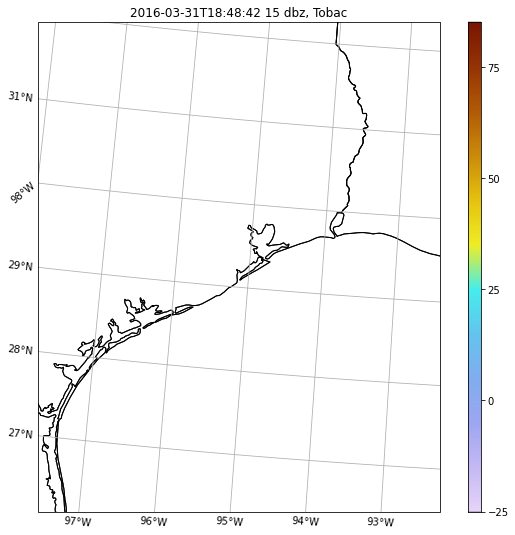

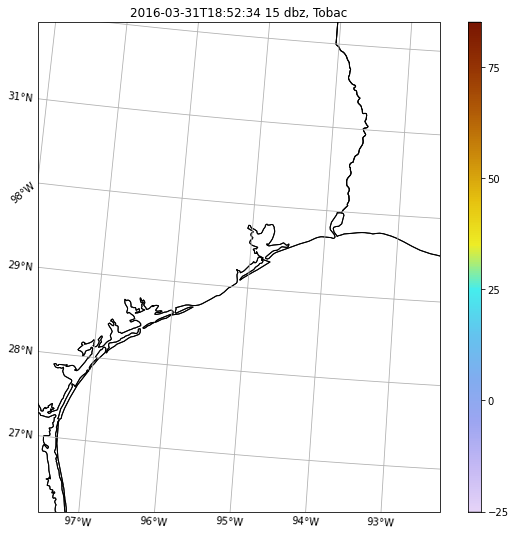

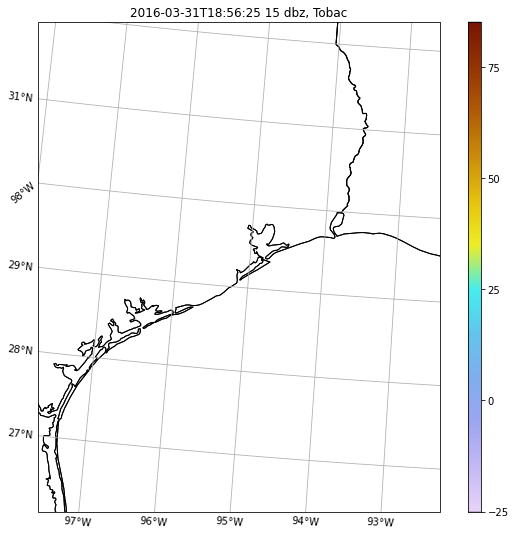

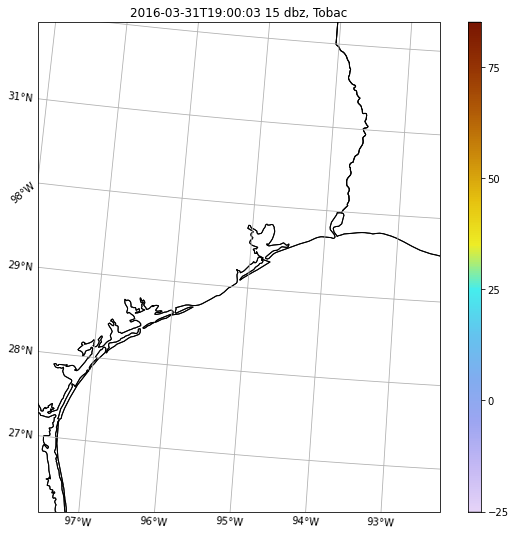

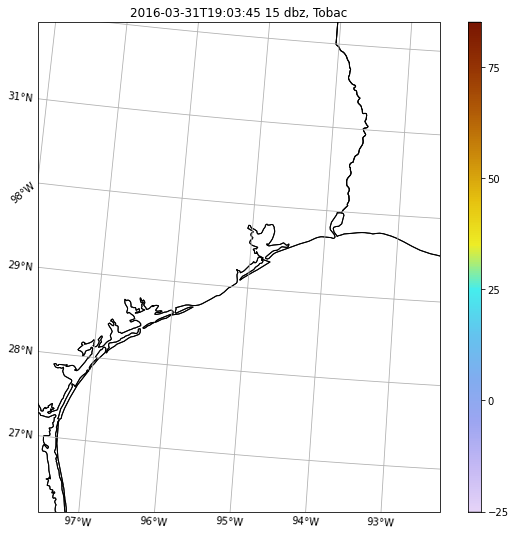

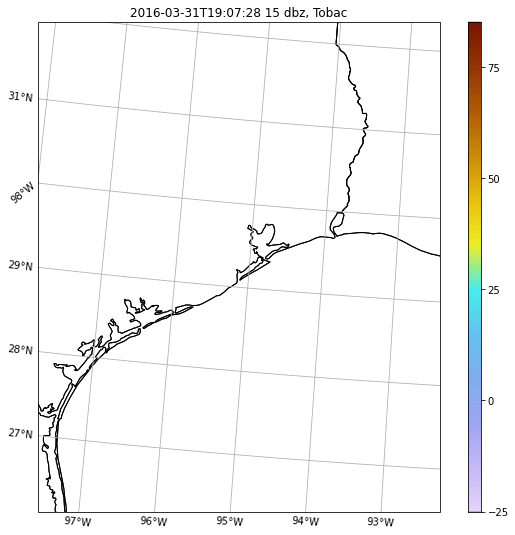

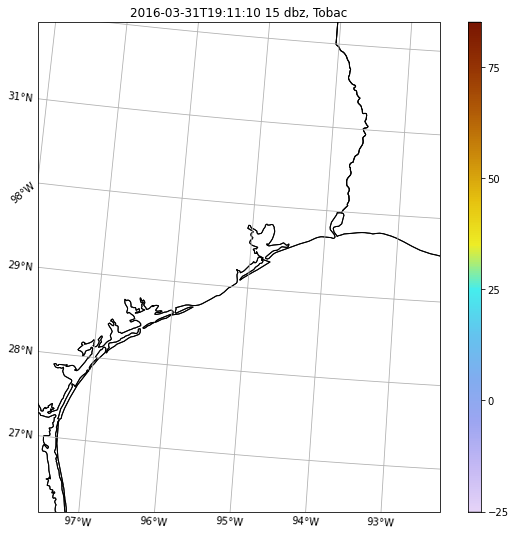

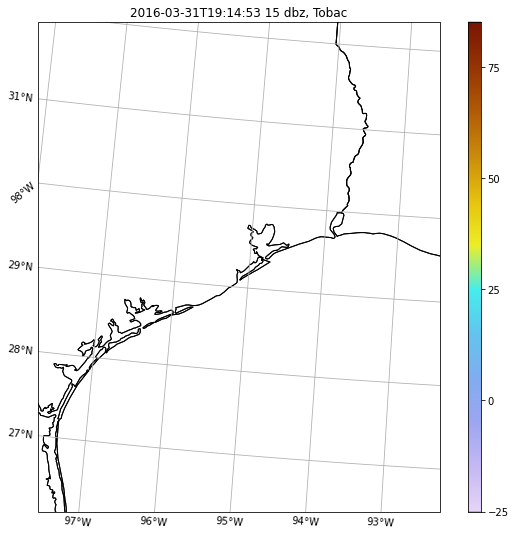

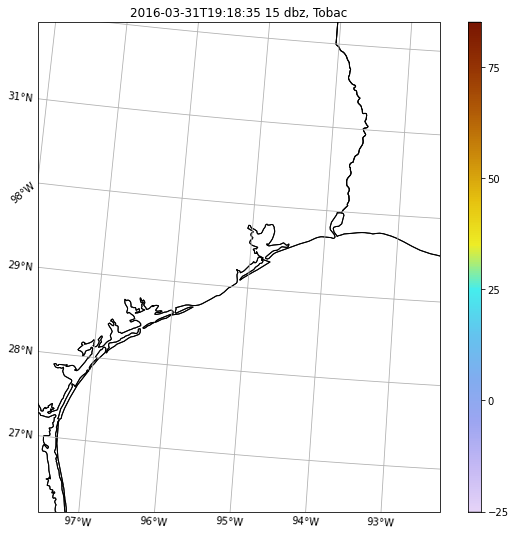

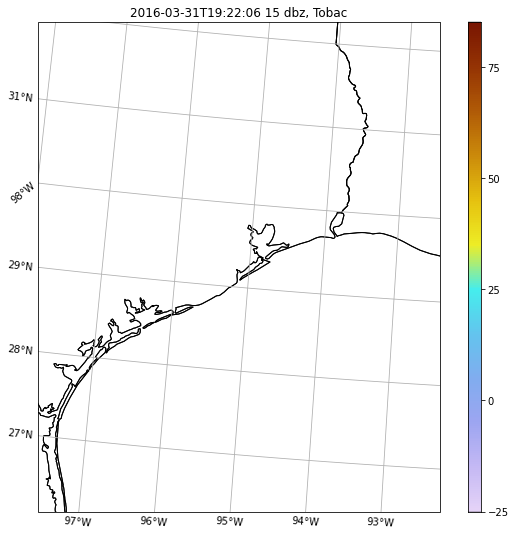

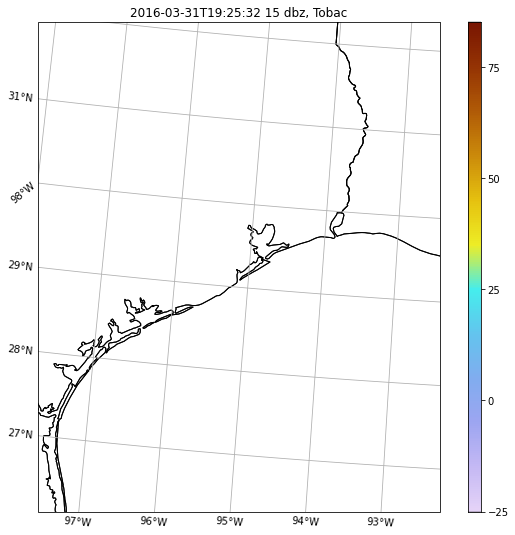

In [63]:
for i in range(len(nc_grid.time)):
#i = 5
    time_index = i

    time_step = str(nc_grid['time'][time_index].values)

    fig = plt.figure(figsize=(9,9))
    fig.set_canvas(plt.gcf().canvas)
    plot(time_index,data,maxrefl,Features, refl_mask,Track,nc_grid,15,longitude,latitude,nc_lons,nc_lats)
    fig.savefig('20220604_tobac_15dbz_tracks'+str(time_index)+'_KHGX.png')


In [ ]:
num_features = []
mean_feature_size = []
max_feature_size = []
for i in range(len(nc_grid.time)):
    num_features.append(len(np.unique(refl_mask['segmentation_mask'][i,:,:])))
    j = np.where(Features.frame == i)
    if len(j[0]) == 0:
        mean_feature_size.append(0)
        max_feature_size.append(0)
    else:
        mean_feature_size.append(np.nanmean(Features.areas[j]))
        max_feature_size.append(np.nanmax(Features.areas[j]))

        
#cell_duration